# KKBox Customer Lifetime Value Analysis

---

# Part 2: <font color=green>*Survival, Hazard, and LTV Analysis*</font>

---

In [47]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime 

# Imports for CLV
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

## Import and Prep Data

In [35]:
# Import Transaction Files
CLV_Feb2017 = pd.read_csv('Tenure-Churn-Data')

## 1) Survival Analysis

With the help of Survival Analysis we can focus on churn prevention efforts of high-value customers with low survival time. This analysis also helps us to calculate Customer Life Time Value. In this use case, Event is defined as the time at which the customer churns / unsubscribe. Time of origin is defined as the time at which the customer starts the service/subscription with a company. Time scale could be months, or weeks. The difference between the time of event and the time origin gives us the time to event.

### <font color=purple>Overall Population</font>

First we will take an overall observation of all users to get the big picture of what is the underlying behavior. 

In [36]:
CLV_Feb2017[['is_churn','tenure']]

,is_churn,tenure
0,0,117
1,0,600
2,0,759
3,0,479
4,0,419
...,...,...
877156,0,789
877157,0,765
877158,1,770
877159,0,700


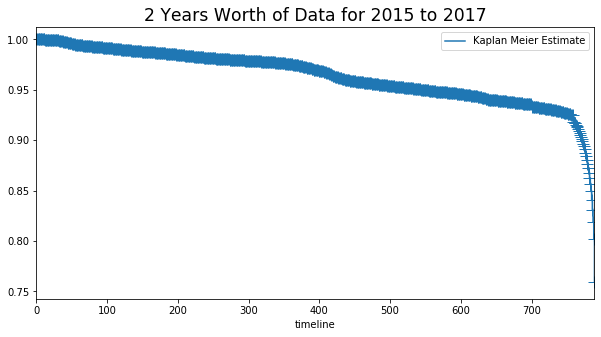

In [45]:
## Time to event data of censored and event data
T = CLV_Feb2017['tenure']

## It has the churned (1) and censored is (0)
E = CLV_Feb2017['is_churn']

# Instantiate Model
kmf = KaplanMeierFitter()

## Fit the data into the model
kmf.(T, E, label='Kaplan Meier Estimate')

## Create an estimate
plt.figure(figsize=(10,5))
plt.title('2 Years Worth of Data for 2015 to 2017', fontsize='xx-large')
kmf.plot(show_censors=True, ci_show=True)

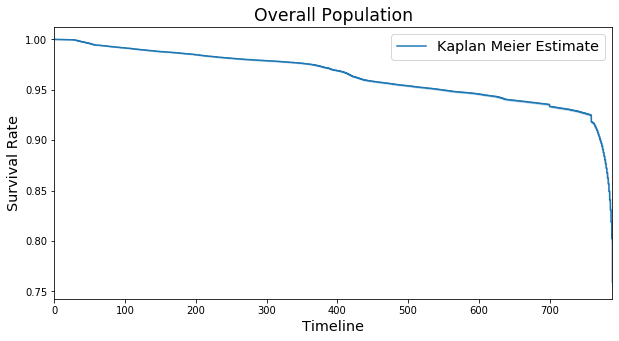

In [13]:
## Fit the data into the model
kmf.fit(T, E, label='Kaplan Meier Estimate')

## Create an estimate
plt.figure(figsize=(10,5))
kmf.plot()

# Plot Details
plt.title('Overall Population', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')

## 2) Cox Proportional Hazard Model (Survival Regression)

### - <font color=blue>Data Pre-Processing</font> -

In [14]:
# Specify the Continuous and Categorical features we will include in our regression model
cont_feat = ['tenure','unique_payment_plans']
cat_feat = ['registered_via','discount']

# Create df for regression model
CLV_Feb2016_Cox = CLV_Feb2016[['is_churn'] + cont_feat + cat_feat]

# Encode Categoricals
CLV_Feb2016_Cox = pd.get_dummies(data=CLV_Feb2016_Cox, columns=cat_feat, prefix_sep='_',drop_first=True)

# Use PCA to make 1 component for 'registered_via' to prevent multicolinearity errors
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
CLV_Feb2016_Cox['registered_via_PCA'] = pca.fit_transform(CLV_Feb2016_Cox[['registered_via_4','registered_via_7','registered_via_9','registered_via_13']])

CLV_Feb2016_Cox = CLV_Feb2016_Cox.drop(['registered_via_4','registered_via_7','registered_via_9','registered_via_13'], axis=1)

### - <font color=blue>Build CPH Regression Model</font> -

In [20]:
# Instantiate a cph object
cph = CoxPHFitter()   

# Fit the data to train the model
model = cph.fit(CLV_Feb2016_Cox, duration_col='tenure', event_col='is_churn')

### - <font color=blue>Evaluate Model</font> -

In [21]:
# show model summary
model.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
unique_payment_plans,-0.744402,0.475018,0.008704,-0.761461,-0.727342,0.466983,0.483192,-85.523440,0.000000e+00,inf
discount_No Discount,0.193144,1.213057,0.017109,0.159612,0.226676,1.173056,1.254423,11.289354,1.481220e-29,95.769128
registered_via_PCA,0.712008,2.038080,0.006842,0.698598,0.725419,2.010931,2.065596,104.060375,0.000000e+00,inf


In [41]:
model.confidence_intervals_

,95% lower-bound,95% upper-bound
unique_payment_plans,-0.761461,-0.727342
discount_No Discount,0.159612,0.226676
registered_via_PCA,0.698598,0.725419


### - <font color=blue>Calculate and Evaluate LT and LTV</font> -

In [28]:
# Make new column for LT and LTV
CLV_Feb2016['LT'] = model.predict_expectation(CLV_Feb2016_Cox)

Text(0.5, 1.0, 'Distribution of Observed Tenure for 2015-2017')

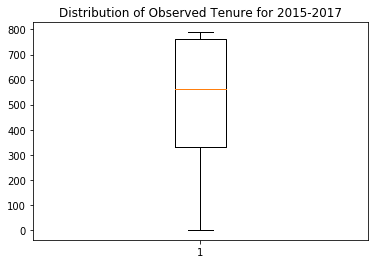

In [43]:
plt.boxplot(CLV_Feb2016['tenure'])
plt.title('Distribution of Observed Tenure for 2015-2017')

Text(0.5, 1.0, 'Distribution of Expected Lifetime')

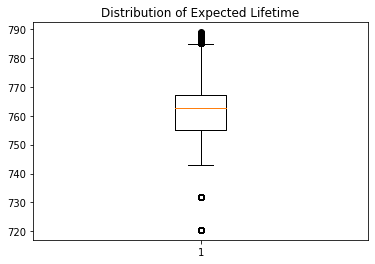

In [30]:
plt.boxplot(CLV_Feb2016['LT'])
plt.title('Distribution of Expected Lifetime')

In [46]:
CLV_Feb2016

,Unnamed: 0,is_churn,tenure,unique_payment_plans,registered_via,discount,LT
0,0,0,117,2,13,No Discount,767.210132
1,1,0,600,1,3,No Discount,744.374327
2,2,0,759,2,3,No Discount,767.245598
3,3,0,479,2,3,No Discount,767.245598
4,4,0,419,1,3,No Discount,744.374327
...,...,...,...,...,...,...,...
877156,877156,0,789,2,9,No Discount,755.128526
877157,877157,0,765,2,9,No Discount,755.128526
877158,877158,1,770,1,9,No Discount,720.489460
877159,877159,0,700,2,9,No Discount,755.128526
